In [54]:
# import statements
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import sklearn
import glob
import random
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
from matplotlib.colors import LinearSegmentedColormap

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Set up cartopy shape file so that it can distinguish between land and ocean
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def train_test_splitting(xarray_file):
    """
    Split model data into train and testing. 10 ensemble 
    members for each model are used for training as to 
    not over weight a given model. All remaining ensemble 
    members are used for testing.
    """
    # Find number of ensembles and random indicies of testing versus training ensembels
    Nensembles = len(xarray_file.ensemble_member)
    ensemble_train_indices = random.sample(range(0,Nensembles),9)
    ensemble_test_indices = list(set(list(range(0,Nensembles))).difference(ensemble_train_indices))

    # Select natural and forced trends as well as the training and testing data
    trend_data = xarray_file.to_array()[0]
    NatTrendsTrain = trend_data[ensemble_train_indices,0].to_numpy()
    NatTrendsTest = trend_data[ensemble_test_indices,0].to_numpy()
    ForTrendsTrain = trend_data[ensemble_train_indices,1].to_numpy()
    ForTrendsTest = trend_data[ensemble_test_indices,1].to_numpy()

    return(NatTrendsTrain, NatTrendsTest, ForTrendsTrain, ForTrendsTest)

def model_ensemble_reshaper(trends):
    """
    Takes a given models testing or trainging data and 
    reshapes it so that timeperiods from different ensembles
    of a given model are treated equally.
    """
    reshaped_trends = np.reshape(trends, (np.shape(trends)[0]*np.shape(trends)[1], 72,144))
    return(reshaped_trends)

def predictor_reshaper(trends):
    """
    Takes maps of trends and reshapes grid points into a vector.
    """
    PredictorVector = np.reshape(trends, (np.shape(trends)[0], np.shape(trends)[1]*np.shape(trends)[2]))
    return(PredictorVector)

def tropical_mean_trend(trends, land_sea_mask):
    """ 
    Takes map of trends and finds average over the 30S-30N region.
    """
    ocean_trends = np.array([np.ma.masked_array(data=trends[i], mask=land_sea_mask, fill_value=np.nan).filled() for i in range(len(trends))])
    land_trends = np.array([np.ma.masked_array(data=trends[i], mask=abs(land_sea_mask-1), fill_value=np.nan).filled() for i in range(len(trends))])

    ReshapedTrends = np.reshape(trends[:,60:72,:], (np.shape(trends)[0],12*144))
    TropicalAverageTrend = np.average(ReshapedTrends, axis=1)
    TropicalOceanTrend = np.nanmean(np.reshape(ocean_trends[:,60:72,:], (np.shape(ocean_trends)[0],12*144)), axis=1)
    TropicalLandTrend = np.nanmean(np.reshape(land_trends[:,60:72,:], (np.shape(land_trends)[0],12*144)), axis=1)

    return(TropicalAverageTrend, TropicalOceanTrend, TropicalLandTrend)

def is_land(x, y):
    """
    Uses knowledge of land points to decide whether given location 
    is land or ocean. X is longitude and Y is latitude."""
    return land.contains(sgeom.Point(x, y))*1

# set path to data
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*.nc'
ModelDataFiles = glob.glob(path_to_data)

# create land sea mask
sample_grid = xr.open_dataset(ModelDataFiles[0]) 
latitudes = sample_grid.Lat.to_numpy()
longitudes = sample_grid.Lon.to_numpy() - 180
land_sea_mask = []
for x in longitudes:
    land_sea_mask_at_latitude = []
    for y in latitudes:
        land_sea_mask_at_latitude.append(is_land(x, y))
    land_sea_mask.append(land_sea_mask_at_latitude)
land_sea_mask = np.transpose(land_sea_mask)
TraingPredictorData = []
TrainingTargetData = []
TestingPredictorData = []
TestingTargetData = []
for datafile in ModelDataFiles:
    xarray_file = xr.open_dataset(datafile) 

    # find training and testing data for natural and forced trends
    NatTrendsTrain, NatTrendsTest, ForTrendsTrain, ForTrendsTest = train_test_splitting(xarray_file)

    # reshape trends so that trend maps from different time periods and ensembles are treated equal
    NatTrendsTrain = model_ensemble_reshaper(NatTrendsTrain)
    NatTrendsTest = model_ensemble_reshaper(NatTrendsTest)
    ForTrendsTrain = model_ensemble_reshaper(ForTrendsTrain)
    ForTrendsTest = model_ensemble_reshaper(ForTrendsTest)

    # weight trend maps by cosine of latitude
    weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
    NatTrendsTrain_weighted = np.multiply(NatTrendsTrain, weights[np.newaxis,:,np.newaxis])
    NatTrendsTest_weighted = np.multiply(NatTrendsTest, weights[np.newaxis,:,np.newaxis])
    ForTrendsTrain_weighted = np.multiply(ForTrendsTrain, weights[np.newaxis,:,np.newaxis])
    ForTrendsTest_weighted = np.multiply(ForTrendsTest, weights[np.newaxis,:,np.newaxis])

    
    # true trend maps are sum of natural and forced trends
    TrueTrendsTrain = NatTrendsTrain_weighted + ForTrendsTrain_weighted
    TrueTrendsTest = NatTrendsTest_weighted + ForTrendsTest_weighted
    
    # reshape predictors as vector
    TrainingTrends_vectors = predictor_reshaper(TrueTrendsTrain)
    TestingTrends_vectors = predictor_reshaper(TrueTrendsTest)

    # find tropical mean trend value
    NatTrendsTrainTropicalMean = np.transpose(tropical_mean_trend(NatTrendsTrain_weighted, land_sea_mask))
    NatTrendsTestTropicalMean = np.transpose(tropical_mean_trend(NatTrendsTest_weighted, land_sea_mask))
    ForTrendsTrainTropicalMean = np.transpose(tropical_mean_trend(ForTrendsTrain_weighted, land_sea_mask))
    ForTrendsTestTropicalMean = np.transpose(tropical_mean_trend(ForTrendsTest_weighted, land_sea_mask))

    [TraingPredictorData.append(TrainingTrends_vectors[i]) for i in range(len(TrainingTrends_vectors))]
    [TrainingTargetData.append([NatTrendsTrainTropicalMean[i], ForTrendsTrainTropicalMean[i]]) 
    for i in range(len(ForTrendsTrainTropicalMean))]
    [TestingPredictorData.append(TestingTrends_vectors[i]) for i in range(len(TestingTrends_vectors))]
    [TestingTargetData.append([NatTrendsTestTropicalMean[i], ForTrendsTestTropicalMean[i]]) 
    for i in range(len(ForTrendsTestTropicalMean))]

TraingPredictorData = np.array(TraingPredictorData)
TrainingTargetData = np.reshape(TrainingTargetData, (np.shape(TrainingTargetData)[0], 
                                np.shape(TrainingTargetData)[1]*np.shape(TrainingTargetData)[2]))
TestingPredictorData = np.array(TestingPredictorData)
TestingTargetData = np.reshape(TestingTargetData, (np.shape(TestingTargetData)[0], 
                                np.shape(TestingTargetData)[1]*np.shape(TestingTargetData)[2]))

In [55]:
latitudes[60:72]

array([61.25, 63.75, 66.25, 68.75, 71.25, 73.75, 76.25, 78.75, 81.25,
       83.75, 86.25, 88.75], dtype=float32)

In [56]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import model_selection

pls2 = PLSRegression(n_components=6)
pls_model = pls2.fit(TraingPredictorData, TrainingTargetData)
Y_pred = pls2.predict(TestingPredictorData)

Text(0.5, 1.0, 'R^2 = 0.729')

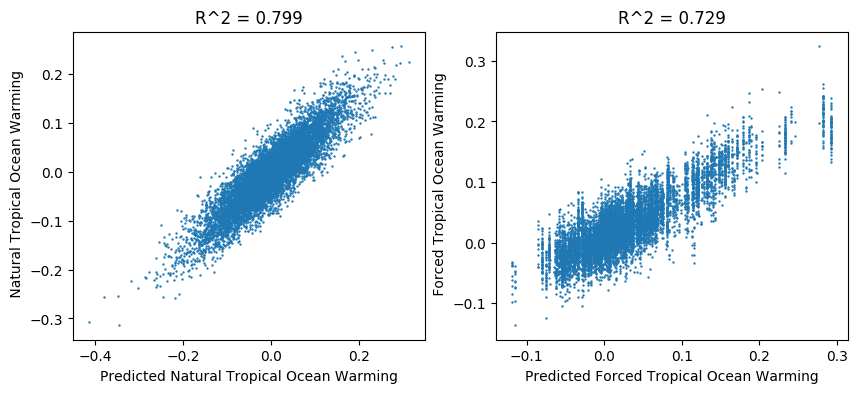

In [57]:
from scipy import stats
fig, axs = plt.subplots(1,2, figsize=(10,4))

################## Natural Predictions ####################
axs[0].scatter(TestingTargetData[:,1], Y_pred[:,1], s=0.5)
axs[0].set_xlabel('Predicted Natural Tropical Ocean Warming')
axs[0].set_ylabel(' Natural Tropical Ocean Warming')
R2 = stats.pearsonr(TestingTargetData[:,1], Y_pred[:,1])[0]**2
axs[0].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

################## Forced Predictions ####################
axs[1].scatter(TestingTargetData[:,4], Y_pred[:,4], s=0.5)
axs[1].set_xlabel('Predicted Forced Tropical Ocean Warming')
axs[1].set_ylabel(' Forced Tropical Ocean Warming')
R2 = stats.pearsonr(TestingTargetData[:,4], Y_pred[:,4])[0]**2
axs[1].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

Text(0.5, 1.0, 'R^2 = 0.753')

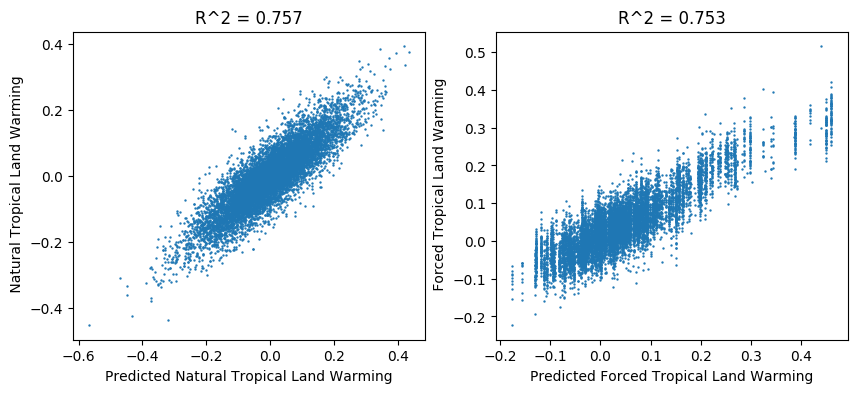

In [58]:
from scipy import stats
fig, axs = plt.subplots(1,2, figsize=(10,4))

################## Natural Predictions ####################
axs[0].scatter(TestingTargetData[:,2], Y_pred[:,2], s=0.5)
axs[0].set_xlabel('Predicted Natural Tropical Land Warming')
axs[0].set_ylabel(' Natural Tropical Land Warming')
R2 = stats.pearsonr(TestingTargetData[:,2], Y_pred[:,2])[0]**2
axs[0].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

################## Forced Predictions ####################
axs[1].scatter(TestingTargetData[:,5], Y_pred[:,5], s=0.5)
axs[1].set_xlabel('Predicted Forced Tropical Land Warming')
axs[1].set_ylabel(' Forced Tropical Land Warming')
R2 = stats.pearsonr(TestingTargetData[:,5], Y_pred[:,5])[0]**2
axs[1].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

Text(0.5, 1.0, 'R^2 = 0.745')

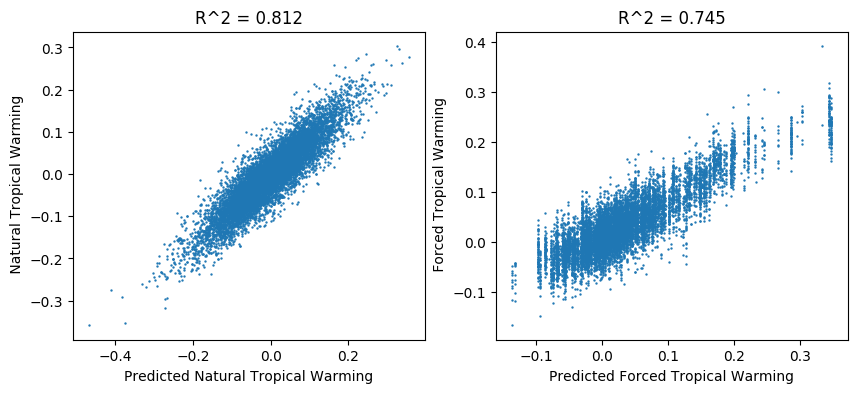

In [59]:
from scipy import stats
fig, axs = plt.subplots(1,2, figsize=(10,4))

################## Natural Predictions ####################
axs[0].scatter(TestingTargetData[:,0], Y_pred[:,0], s=0.5)
axs[0].set_xlabel('Predicted Natural Tropical Warming')
axs[0].set_ylabel(' Natural Tropical Warming')
R2 = stats.pearsonr(TestingTargetData[:,0], Y_pred[:,0])[0]**2
axs[0].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

################## Forced Predictions ####################
axs[1].scatter(TestingTargetData[:,3], Y_pred[:,3], s=0.5)
axs[1].set_xlabel('Predicted Forced Tropical Warming')
axs[1].set_ylabel(' Forced Tropical Warming')
R2 = stats.pearsonr(TestingTargetData[:,3], Y_pred[:,3])[0]**2
axs[1].set_title('R^2 = {accuracy}'.format(accuracy=str(R2)[:5]))

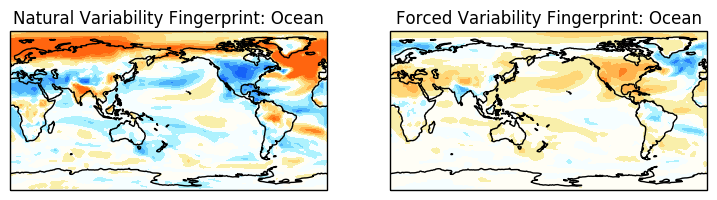

In [60]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-.00009, .00009, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Ocean')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,1], (72,144)), coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
####################################################################################
ax[1].coastlines()
#ax[1].set_extent([0.0, -1, -90.0, 90.0])
ax[1].set_title('Forced Variability Fingerprint: Ocean')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,4], (72,144)), coord=lon_bins)

im = ax[1].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)




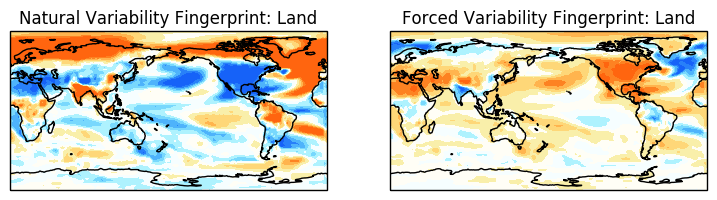

In [61]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-.00009, .00009, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Land')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,2], (72,144)), coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
####################################################################################
ax[1].coastlines()
#ax[1].set_extent([0.0, -1, -90.0, 90.0])
ax[1].set_title('Forced Variability Fingerprint: Land')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,5], (72,144)), coord=lon_bins)

im = ax[1].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)




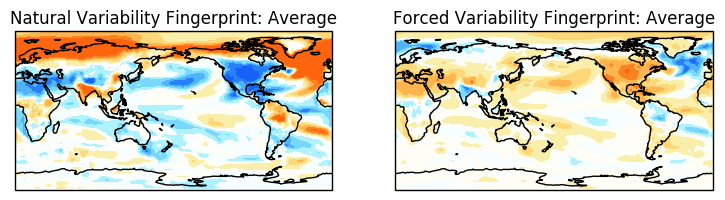

In [62]:
#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-.00009, .00009, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax[0].coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax[0].set_title('Natural Variability Fingerprint: Average')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,0], (72,144)), coord=lon_bins)
im = ax[0].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
####################################################################################
ax[1].coastlines()
#ax[1].set_extent([0.0, -1, -90.0, 90.0])
ax[1].set_title('Forced Variability Fingerprint: Average')
coef_map_cyclic, lon = add_cyclic_point(np.reshape(pls_model.coef_[:,3], (72,144)), coord=lon_bins)

im = ax[1].contourf(lon, lat_bins, coef_map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)


